<a href="https://colab.research.google.com/github/abirharrasse/2023-GenAI-Hackathon/blob/main/Classifying_peppers_AI_challenge_ChaithanyaAbir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# You may install and import your preferred packages
!pip install torch torchvision transformers tqdm datasets -q

In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from transformers import ViTConfig, ViTForImageClassification, ViTImageProcessor
from torch.optim import AdamW
from tqdm import tqdm
import datasets
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt


In [ ]:
model_name = 'WinKawaks/vit-tiny-patch16-224'
train_dir = 'peppers_experiment/train'
val_dir = 'peppers_experiment/val_test'
num_classes = 2

# Define image transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
dataset = datasets.load_dataset('bdzyubak/peppers_experiment')

train_dataset = dataset['train']
valid_dataset = dataset['val']

# Custom dataset to apply transformation
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None, drop_indices=None):

        self.hf_dataset = hf_dataset
        self.transform = transform

        # Generate a list of indices for the dataset excluding the ones to drop
        self.indices = list(range(len(hf_dataset)))
        if drop_indices:
            drop_indices = [int(i) for i in drop_indices]  # Convert tensors to integers
            self.indices = [i for i in self.indices if i not in drop_indices]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Get the actual dataset index from the filtered list
        actual_idx = self.indices[idx]

        # Assuming the dataset returns a tuple (image, label)
        data = self.hf_dataset[actual_idx]
        image, label = data['image'], data['label']  # Direct tuple unpacking

        if self.transform:
            image = self.transform(image)

        return image, label


# Create the train and validation datasets
train_dataset = CustomDataset(train_dataset, transform=train_transform)
val_dataset = CustomDataset(valid_dataset, transform=val_transform)

### **Explaining how I proceeded**
- I kept the new configuration that came with the notebook (with the same number of layers...) and tried to increase the number of epochs, the batch size, the learning rate of the gradient descent. Several combinations leaded to only ~6% improvement.
- I thought that the initial configuration of the model along with its weights should work better by construction, so no need to make changes on the architecture. We only have to backpropagate with the examples we have in the training set to adjust the weights more to our dataset. This leaded to ~20% improvement.
- Some other changes consisted of changing the batch size to 8 or 32. 16 seemed to be the best choice.
- I changed the learning rate between smaller and higher values (1e-2 to 1e-5), lr = 2e-3 seemed to lead to better results.
- As of the architecture per see, I eliminated the extra configuration as mentioned above but added a Dropout layer to prevent the ViT from overfitting the small data we have. Here too, I changed the p parameter and found that p = 0.2 achieves better results (We can test with the grid search implemented below).

We plot the misclassified images to understand how our model fails. We find that the errors are mostly due to the images being in grayscale (which contradicts the essence of the task) or because the image contains both types (or what appear to be both types) of peppers.

### Training our model

In [ ]:
# Model setup
num_epochs = 7

model_name = "google/vit-base-patch16-224-in21k"  # Pre-trained on ImageNet-21k
model = ViTForImageClassification.from_pretrained(model_name, num_labels=num_classes)
processor = ViTImageProcessor.from_pretrained(model_name)

for param in model.vit.parameters():
    param.requires_grad = False # Freezing the model


def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return total_loss / len(dataloader), correct / total

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).logits
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return total_loss / len(dataloader), correct / total

def run_epochs(pt, lr, batch_size):
    best_val_acc = 0
    total_val_acc = 0

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
        # Only train the classification head
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=pt),
        torch.nn.Linear(model.config.hidden_size, num_classes)
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        total_val_acc += val_acc
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        scheduler.step()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_produce_classifier.pth')

    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f'Average Validation Accuracy: {total_val_acc/num_epochs}')
    print(f"Number of training images: {len(train_dataset)}")
    print(f"Number of validation images: {len(val_dataset)}")
    return total_val_acc/num_epochs

batch_size_init = 16
lr_init = 2e-3
p_init = 0.2
_ = run_epochs(p_init, lr_init, batch_size_init)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7


100%|██████████| 2/2 [00:20<00:00, 10.49s/it]


Train Loss: 0.6395, Train Acc: 0.6179
Val Loss: 0.5988, Val Acc: 0.7812
Epoch 2/7


100%|██████████| 2/2 [00:20<00:00, 10.11s/it]


Train Loss: 0.4964, Train Acc: 0.8130
Val Loss: 0.5397, Val Acc: 0.7188
Epoch 3/7


100%|██████████| 2/2 [00:19<00:00,  9.57s/it]


Train Loss: 0.4311, Train Acc: 0.8293
Val Loss: 0.5193, Val Acc: 0.7500
Epoch 4/7


100%|██████████| 2/2 [00:19<00:00,  9.94s/it]


Train Loss: 0.3489, Train Acc: 0.8943
Val Loss: 0.5105, Val Acc: 0.7500
Epoch 5/7


100%|██████████| 2/2 [00:19<00:00,  9.66s/it]


Train Loss: 0.3393, Train Acc: 0.8862
Val Loss: 0.5082, Val Acc: 0.7188
Epoch 6/7


100%|██████████| 2/2 [00:20<00:00, 10.34s/it]


Train Loss: 0.3486, Train Acc: 0.8699
Val Loss: 0.5077, Val Acc: 0.7188
Epoch 7/7


100%|██████████| 2/2 [00:19<00:00,  9.87s/it]

Train Loss: 0.3447, Train Acc: 0.8780
Val Loss: 0.5078, Val Acc: 0.7188
Best Validation Accuracy: 0.7812
Average Validation Accuracy: 0.7366071428571429
Number of training images: 123
Number of validation images: 32


### Using our model to predict classes of evaluation data

In [ ]:
def load_model(model_name, num_classes, weight_path, device):
    """Load and reinitialize a ViT model for image classification."""
    model = ViTForImageClassification.from_pretrained(model_name, num_labels=num_classes)
    processor = ViTImageProcessor.from_pretrained(model_name)
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2),
        torch.nn.Linear(model.config.hidden_size, num_classes)
    )
    model.load_state_dict(torch.load(weight_path))  # Load trained weights
    model.to(device)
    model.eval()  # Set model to evaluation mode
    return model, processor

def evaluate_model(model, data_loader, device):
    """Evaluate model and collect misclassified images, predictions, true labels, and their indices."""
    misclassified_images, misclassified_preds, misclassified_true, misclassified_indices = [], [], [], []

    with torch.no_grad():
        for i, batch in enumerate(tqdm(data_loader)):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)

            misclassified = preds != labels

            misclassified_images.extend(images[misclassified])
            misclassified_preds.extend(preds[misclassified])
            misclassified_true.extend(labels[misclassified])

            # Storing the indices of the misclassified images
            misclassified_indices.extend(torch.where(misclassified)[0] + i * data_loader.batch_size)

    return misclassified_images, misclassified_preds, misclassified_true, misclassified_indices


def denormalize(img, mean, std):
    """Denormalize a tensor image for display."""
    mean = torch.tensor(mean).view(1, 1, 3)
    std = torch.tensor(std).view(1, 1, 3)
    img = img * std + mean
    return img

def plot_image(img, true_label, pred_label):
    """Plot a single misclassified image with true and predicted labels."""
    img = img.cpu().permute(1, 2, 0)  # Convert to [H, W, C]
    img = denormalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).numpy()
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')
    plt.show()

def display_misclassified_images(misclassified_images, misclassified_preds, misclassified_true, num_to_display=10):
    """Display up to num_to_display misclassified images."""
    for i in range(min(num_to_display, len(misclassified_images))):
        plot_image(misclassified_images[i], misclassified_true[i].item(), misclassified_preds[i].item())


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-0fe456f3e492>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globa

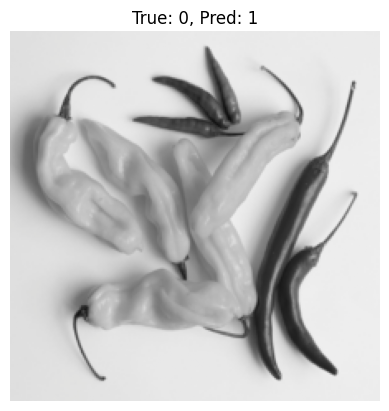

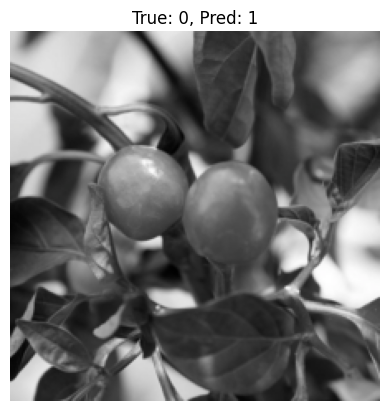

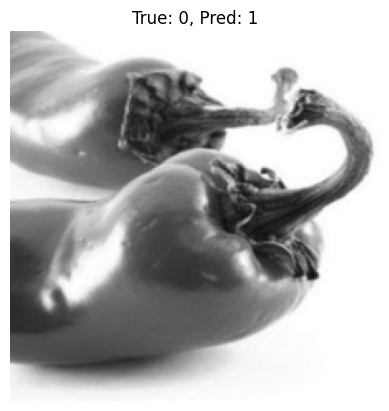

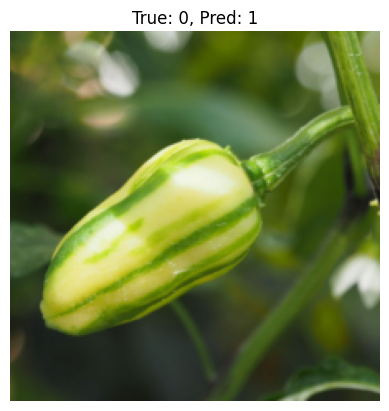

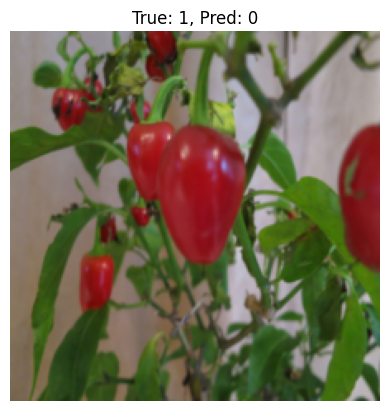

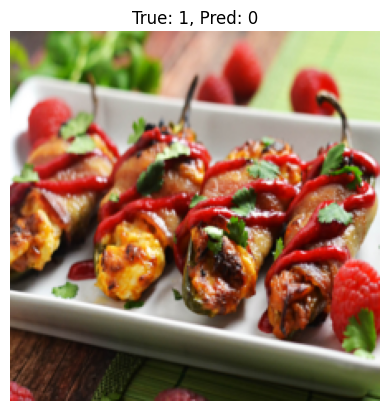

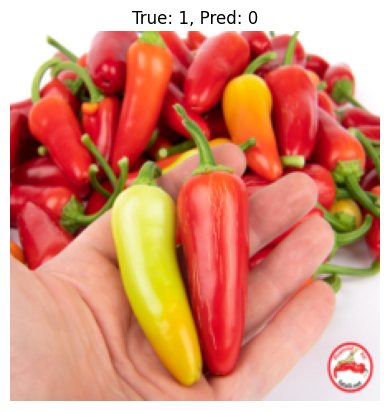

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "google/vit-base-patch16-224-in21k"
num_classes = 2
weight_path = "best_produce_classifier.pth"
model, processor = load_model(model_name, num_classes, weight_path, device)
val_loader = val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size_init)
misclassified_images, misclassified_preds, misclassified_true, misclassification_indices = evaluate_model(model, val_loader, device)
display_misclassified_images(misclassified_images, misclassified_preds, misclassified_true, num_to_display=10)

### Removing Gray images and reevaluating our model

In [ ]:

drop_indices = [int(i) for i in misclassification_indices[:-4]]
valid_indices = [i for i in range(len(valid_dataset)) if i not in drop_indices]
fval_dataset = valid_dataset.select(valid_indices)
fval_dataset = CustomDataset(fval_dataset, transform=val_transform)
best_val_acc = 0
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_init, shuffle=True)
val_loader2 = DataLoader(fval_dataset, batch_size=batch_size_init, num_workers=0)
criterion = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=lr_init)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    val_loss, val_acc = evaluate(model, val_loader2, criterion, device)
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(fval_dataset)}")

Epoch 1/7


100%|██████████| 2/2 [00:17<00:00,  8.96s/it]


Val Loss: 0.5828, Val Acc: 0.8621
Epoch 2/7


100%|██████████| 2/2 [00:18<00:00,  9.40s/it]


Val Loss: 0.5828, Val Acc: 0.8621
Epoch 3/7


100%|██████████| 2/2 [00:17<00:00,  8.70s/it]


Val Loss: 0.5828, Val Acc: 0.8621
Epoch 4/7


100%|██████████| 2/2 [00:17<00:00,  8.77s/it]


Val Loss: 0.5828, Val Acc: 0.8621
Epoch 5/7


100%|██████████| 2/2 [00:18<00:00,  9.31s/it]


Val Loss: 0.5828, Val Acc: 0.8621
Epoch 6/7


100%|██████████| 2/2 [00:17<00:00,  8.77s/it]


Val Loss: 0.5828, Val Acc: 0.8621
Epoch 7/7


100%|██████████| 2/2 [00:17<00:00,  8.84s/it]

Val Loss: 0.5828, Val Acc: 0.8621
Number of training images: 123
Number of validation images: 29
